# 实例：用随机森林回归填补缺失值

我们从现实中收集的数据，几乎不可能是完美无缺的，往往都会有一些缺失值。面对缺失值，很多人选择的方式是直接将含有缺失值的样本删除，这是一种有效的方法，但是有时候填补缺失值会比直接丢弃样本效果更好，即便我们其实并不知道缺失值的真实样貌。在sklearn中，我们可以使用sklearn.impute.SimpleImputer来轻松地将均值，中值，或者其他最常用的数值填补到数据中。

在这个案例中，我们将使用均值，0，和随机森林回归来填补缺失值，并验证四种状况下的拟合状况，找出对使用的数据集来说最佳的缺失值填补方法。

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer  # 用来填补确实值的类
from sklearn.ensemble import RandomForestRegressor

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
dataset = load_boston()
dataset.data.shape

(506, 13)

先制造缺失，然后再用算法填补对比效果

In [41]:
x_full,y_full = dataset.data,dataset.target

In [42]:
n_samples = x_full.shape[0]
n_features = x_full.shape[1]

In [43]:
n_samples,n_features

(506, 13)

In [44]:
# 首先确定希望嵌入的缺失值比例，这里假设是50%，
rng = np.random.RandomState(0)   # 随机数种子，确认一种随机模式
missing_rate = 0.5
# np.floor向下取整，返回的是.0格式的浮点数
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))

n_missing_samples

3289

In [45]:
# 所有数据要随遍布在数据集的各行各列中，而一个缺失的数据会需要一个行索引和一个列索引
# 如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13中间的列索引，就可以利用这些索引来为数据中任意3289个位置赋空值
# 用0，均值，随机森林来填写这些缺失值，查看回归的结果

In [46]:
# randint(下限，上限，n),在下限和上限之间取出n个整数
missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)

In [47]:
missing_features,missing_samples

(array([12,  5,  0, ..., 11,  0,  2]),
 array([150, 125,  28, ..., 132, 456, 402]))

In [48]:
x_missing = x_full.copy()
y_missing = y_full.copy()
x_missing[missing_samples,missing_features] = np.nan

In [49]:
x_missing = pd.DataFrame(x_missing)
x_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


**使用0和均值填补缺失值**

In [50]:
# 使用均值填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
x_missing_mean = imp_mean.fit_transform(x_missing)  #训练fit+导出predict >>> 特殊的接口 fit_transform
x_missing_mean

array([[3.62757895e+00, 1.80000000e+01, 1.11634641e+01, ...,
        1.85211921e+01, 3.52741952e+02, 4.98000000e+00],
       [2.73100000e-02, 0.00000000e+00, 1.11634641e+01, ...,
        1.85211921e+01, 3.96900000e+02, 9.14000000e+00],
       [2.72900000e-02, 1.07229508e+01, 7.07000000e+00, ...,
        1.85211921e+01, 3.52741952e+02, 1.29917666e+01],
       ...,
       [3.62757895e+00, 1.07229508e+01, 1.19300000e+01, ...,
        2.10000000e+01, 3.52741952e+02, 5.64000000e+00],
       [1.09590000e-01, 0.00000000e+00, 1.19300000e+01, ...,
        2.10000000e+01, 3.93450000e+02, 6.48000000e+00],
       [4.74100000e-02, 0.00000000e+00, 1.19300000e+01, ...,
        1.85211921e+01, 3.96900000e+02, 7.88000000e+00]])

In [51]:
pd.DataFrame(x_missing_mean).isnull().sum()    # 数据中已经没有缺失值了

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [52]:
# 使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)
x_missing_0

array([[0.0000e+00, 1.8000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 0.0000e+00,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 0.0000e+00, 3.9690e+02,
        7.8800e+00]])

In [53]:
pd.DataFrame(x_missing_0).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

**使用随机森林填补缺失值**

### 基本思想

任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。


对于一个有n个特征的数据来说，其中特征T有缺失值，我们就**把特征T当作标签，其他的n-1个特征和原本的标签组成新的特征矩阵。** 那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部分，只有特征没有标签，就是我们需要预测的部分。

1.特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train    
2.特征T不缺失的值：Y_train     
3.特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test    
4.特征T缺失的值：未知，我们需要预测的Y_test    

**这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。**   

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？    
答案是遍历所有的特征，**从缺失最少的开始进行填补**（因为填补缺失最少的特征所需要的准确信息最少）。填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。遍历所有的特征后，数据就完整，不再有缺失值了。


In [54]:
x_missing_reg = x_missing.copy()

In [55]:
# 找出数据集中，缺失值从小到大排列的特征的顺序
# np.argsort() 从小到大顺序所对应的索引
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values

In [56]:
sortindex

array([ 6, 12,  8,  7,  9,  0,  2,  1,  5,  4,  3, 10, 11], dtype=int64)

先用具体的一个特征处理

In [19]:
# 构建新特征矩阵(没有被选中去填充的 特征 + 原始的标签) 和新标签(被选中去填充的特征)
df = x_missing_reg

In [20]:
fillc = df.iloc[:,6]
fillc

0      65.2
1      78.9
2      61.1
3      45.8
4       NaN
       ... 
501    69.1
502    76.7
503    91.0
504    89.3
505     NaN
Name: 6, Length: 506, dtype: float64

In [23]:
# 新特征矩阵
df = pd.concat([df.iloc[:,df.columns!=6],pd.DataFrame(y_full)],axis=1)
df

,0,1,2,3,4,5,7,8,9,10,11,12,0
0,NaN,18.0,NaN,NaN,0.538,NaN,4.0900,1.0,296.0,NaN,NaN,4.98,24.0
1,0.02731,0.0,NaN,0.0,0.469,NaN,4.9671,2.0,NaN,NaN,396.90,9.14,21.6
2,0.02729,NaN,7.07,0.0,NaN,7.185,NaN,2.0,242.0,NaN,NaN,NaN,34.7
3,NaN,NaN,NaN,0.0,0.458,NaN,NaN,NaN,222.0,18.7,NaN,NaN,33.4
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,18.7,NaN,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,NaN,1.0,NaN,21.0,NaN,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,2.2875,1.0,273.0,NaN,396.90,9.08,20.6
503,NaN,NaN,11.93,NaN,0.573,6.976,NaN,NaN,NaN,21.0,NaN,5.64,23.9
504,0.10959,0.0,11.93,NaN,0.573,NaN,NaN,1.0,NaN,21.0,393.45,6.48,22.0


In [24]:
# 在新特征矩阵中，对含有缺失值的列，进行0填充
df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
df_0

array([[0.0000e+00, 1.8000e+01, 0.0000e+00, ..., 0.0000e+00, 4.9800e+00,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 0.0000e+00, ..., 3.9690e+02, 9.1400e+00,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 0.0000e+00, 0.0000e+00,
        3.4700e+01],
       ...,
       [0.0000e+00, 0.0000e+00, 1.1930e+01, ..., 0.0000e+00, 5.6400e+00,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 3.9345e+02, 6.4800e+00,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 7.8800e+00,
        1.1900e+01]])

In [25]:
# 找出训练集和测试集
# ytrain 是被选中要填充的特征中(即标签)，存在的那些值，非空值
ytrain = fillc[fillc.notnull()]

In [26]:
# ytest 是被选中要填充的特征中(即标签)，不存在的那些值，即空值
# 不需要ytest的值，需要的是yest所带的索引
ytest = fillc[fillc.isnull()]

In [27]:
xtrain = df_0[ytrain.index,:]
xtest = df_0[ytest.index,:]

In [29]:
# 随机森林回归填补缺失值
rfc = RandomForestRegressor(n_estimators=100)
rfc = rfc.fit(xtrain,ytrain)
ypredict = rfc.predict(xtest)

In [30]:
# 将填补好的特征返回到原始的特征矩阵中
x_missing_reg.loc[x_missing_reg.iloc[:,6].isnull(),6]=ypredict

In [31]:
x_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.200,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.900,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.100,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.800,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,56.458,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.100,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.700,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.000,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.300,NaN,1.0,NaN,21.0,393.45,6.48


对全部的列进行填充

In [57]:
for i in sortindex:
    # 构建特征矩阵和新标签
    df = x_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns!=i],pd.DataFrame(y_full)],axis=1)
    
    # 在新特征矩阵中，对含有缺失值的列，进行0填充
    df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
    
    # 找出训练集和测试集
    ytrain = fillc[fillc.notnull()]
    ytest = fillc[fillc.isnull()]
    xtrain = df_0[ytrain.index,:]
    xtest = df_0[ytest.index,:]
    
    # 随机森林回归填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(xtrain,ytrain)
    ypredict = rfc.predict(xtest)
    
    # 将填补好的特征返回到原始的特征矩阵中
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i]=ypredict

In [58]:
x_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

对空值处理进行评估

In [59]:
X = [x_full,x_missing_mean,x_missing_0,x_missing_reg]
mse = []
for x in X:
    estimator = RandomForestRegressor(random_state=0,n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring="neg_mean_squared_error",cv=5).mean()
    mse.append(scores * -1)

In [60]:
mse  # mse越小越好

[21.571667100368845, 40.848037216676374, 49.626793201980185, 18.83183030073771]

In [63]:
dict(zip(["x_full","x_missing_mean","x_missing_0","x_missing_reg"],mse))

{'x_full': 21.571667100368845,
 'x_missing_mean': 40.848037216676374,
 'x_missing_0': 49.626793201980185,
 'x_missing_reg': 18.83183030073771}

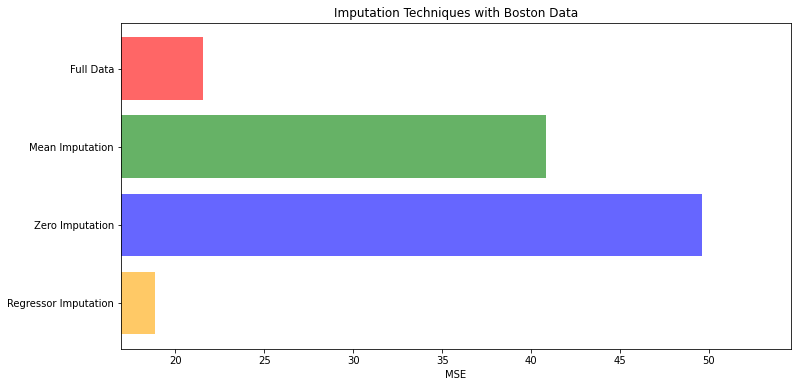

In [76]:
x_labels = ["Full Data"
           ,"Mean Imputation"
           ,"Zero Imputation"
           ,"Regressor Imputation"]
colors = ["r","g",'b','orange']
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i,mse[i],color=colors[i],alpha=0.6,align='center')
ax.set_title("Imputation Techniques with Boston Data")
ax.set_xlim(left=np.min(mse)*0.9,right = np.max(mse)*1.1)   # x的数值区间
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel("MSE")
ax.invert_yaxis()
ax.set_yticklabels(x_labels)
plt.show()